In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio # gif 파일을 만들기 위해 imageio를 사용한다.
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# 패션 MNIST 아이템 불러오기
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = FashionMNIST(root="../data/", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100.0%


Extracting ../data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data/FashionMNIST\raw



100.0%


Extracting ../data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data/FashionMNIST\raw



100.0%


Extracting ../data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data/FashionMNIST\raw



100.0%

Extracting ../data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST\raw



In [4]:
# 생성자 구축
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out=  784
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_out),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [18]:
# 구별자 구축하기
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, self.n_out),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

In [19]:
# 모델 정의하기
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [20]:
# 손실 함수 및 최적화 기법 정의하기
g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()

In [21]:
# 잠재 변수 및 라벨 정의하기
def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [22]:
# 구별자 학습 함수 정의하기
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))
    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()
    return loss.item()

In [23]:
# 생성자 학습 함수 정의하기
def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    loss.backward()
    optimizer.step()
    return loss.item()

In [24]:
# 모델 학습하기
test_noise = noise(64)
l = len(trainloader)
for epoch in range(151):
    g_loss = 0.0
    d_loss = 0.0
    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        fake_data = generator(noise(n)).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)
    
    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)
    if epoch % 10 == 0:
        print("Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r".format(epoch, g_loss/l, d_loss/l))

Epoch 0: g_loss: 3.321 d_loss: 0.736
Epoch 10: g_loss: 1.992 d_loss: 0.732
Epoch 20: g_loss: 1.501 d_loss: 0.917
Epoch 30: g_loss: 1.313 d_loss: 1.004
Epoch 40: g_loss: 1.289 d_loss: 1.020
Epoch 50: g_loss: 1.255 d_loss: 1.044
Epoch 60: g_loss: 1.203 d_loss: 1.072
Epoch 70: g_loss: 1.144 d_loss: 1.120
Epoch 80: g_loss: 1.093 d_loss: 1.162
Epoch 90: g_loss: 1.083 d_loss: 1.153
Epoch 100: g_loss: 1.058 d_loss: 1.173
Epoch 110: g_loss: 1.071 d_loss: 1.180
Epoch 120: g_loss: 1.062 d_loss: 1.188
Epoch 130: g_loss: 0.981 d_loss: 1.233
Epoch 140: g_loss: 1.054 d_loss: 1.183
Epoch 150: g_loss: 1.000 d_loss: 1.207


In [27]:
# 모델 저장하기
torch.save(discriminator.state_dict(), "../models/fmnist_disc.pth")
torch.save(generator.state_dict(), "../models/fmnist_gner.pth")

In [28]:
# 검증 이미지 변화를 gif 파일로 저장하기
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave("fashion_items.gif", imgs)

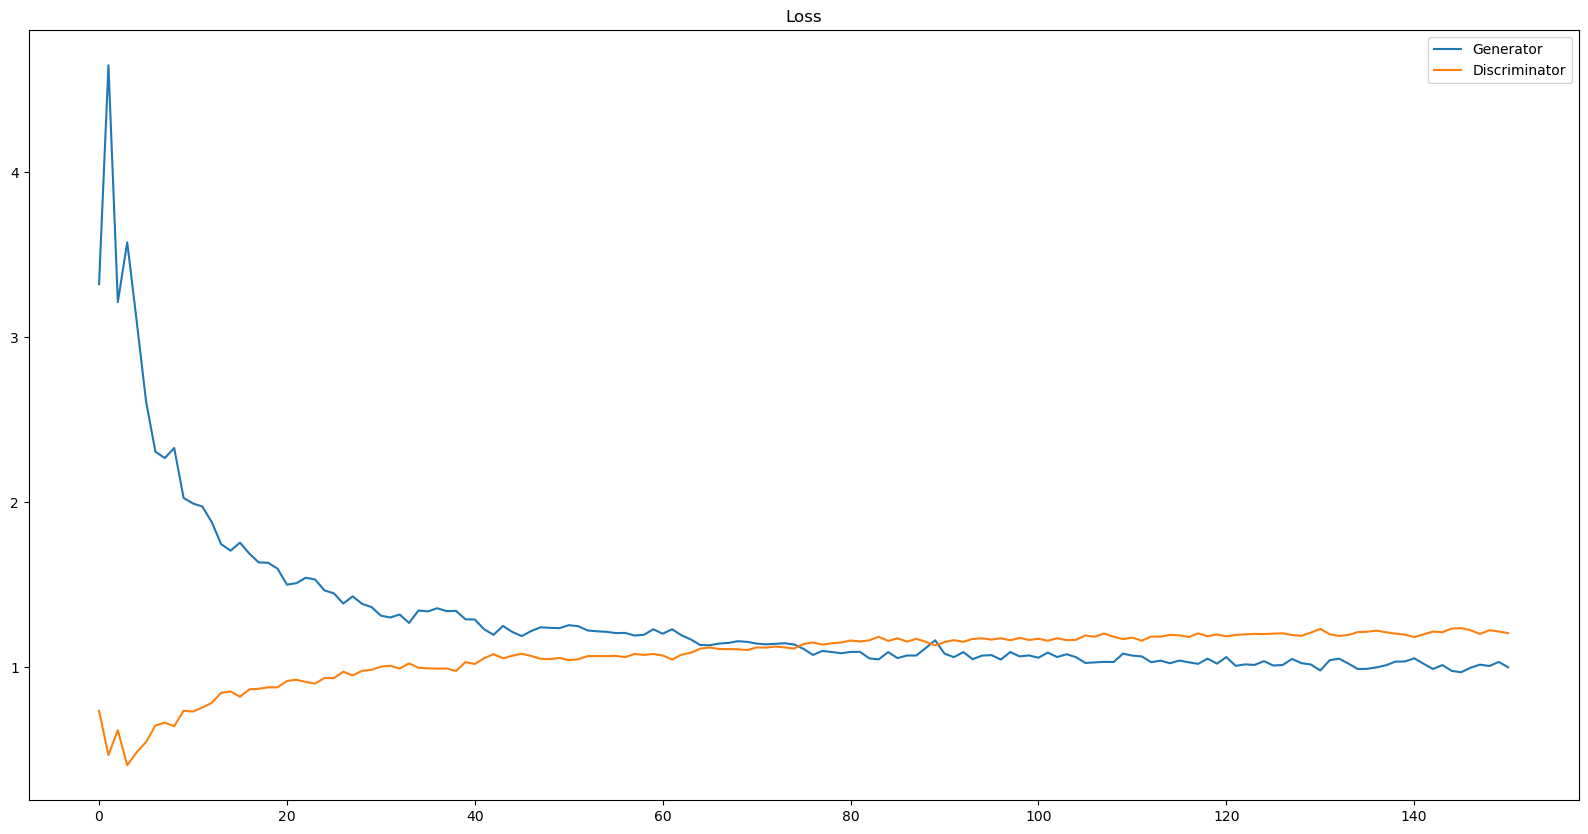

In [29]:
# 손실 함수값 그래프 그리기
plt.figure(figsize=(20, 10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(["Generator", "Discriminator"])
plt.title("Loss")
plt.savefig("gan_loss.png")

In [30]:
# Deep Convolutional GAN
# 생성자 구축하기
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias = False), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 3, 2, bias = False), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 32, 2, bias = False), nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 2, 2, 1, bias = False), nn.Tanh(),
        )
    def forward(self, x):
        x = x.view(-1, self.n_features, 1, 1)
        x = self.conv(x)
        return x

In [31]:
# 구별자 구축하기
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 128, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Conv2d(256, 267, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(256, 1, 3, 2, bias = False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x.view(-1 ,1)